# Load libraries and packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [4]:
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [6]:
from sklearn.tree import plot_tree

In [5]:
from sklearn.metrics import auc, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Load database and some data exploration analysis

In [2]:
df = pd.read_csv("./database/Lending_club/Loan_status_2007-2020Q3.gzip", low_memory=False)

In [3]:
df.loan_status.value_counts()

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: loan_status, dtype: int64

<AxesSubplot:>

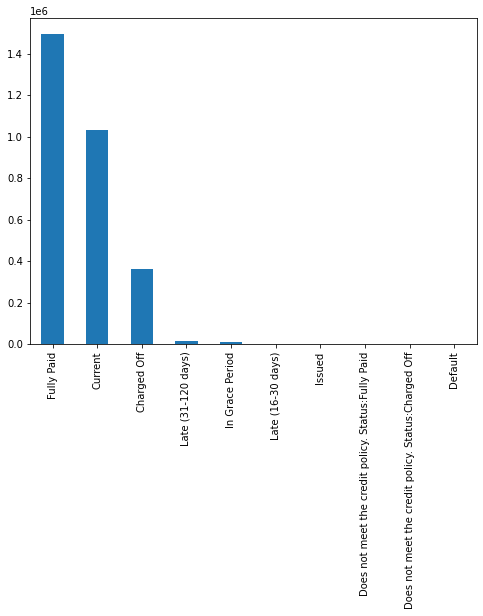

In [98]:
plt.figure(figsize=(8,6))
df.loan_status.value_counts().plot.bar()

In this project we are interested in whether a person is eligible to get a loan or not. That means only two statuses are considered. 
- Fully Paid status means a person paid back for the loan
- Charged Off status means a person could not afford to paid for the loan

In [5]:
df_data = df[(df.loan_status=="Fully Paid")|(df.loan_status=="Charged Off")]

In [6]:
print("Percentage of data after considering only two statuses is", round(df_data.shape[0]/df.shape[0]*100, 2))

Percentage of data after considering only two statuses is 63.59


In [7]:
# Percentage of two loan statuses
df_data.loan_status.value_counts(normalize=True)

Fully Paid     0.805116
Charged Off    0.194884
Name: loan_status, dtype: float64

## Write a function to find columns with high missing value

In [8]:
def find_col_missing_value(threshold):
    df_na_percent = df_data.isna().sum().sort_values(ascending=False)/df_data.shape[0]
    return list(df_na_percent[df_na_percent>threshold].index)

In [9]:
lst_missing_value = find_col_missing_value(0.96)

## Write a function to find columns with only one value (no information)

In [10]:
lst_col = list(df_data.columns)
lst_col = [item for item in lst_col if item not in lst_missing_value]

In [11]:
len(lst_col) # After removing 30 columns there is 112 columns left

112

In [12]:
df_data.loan_amnt.nunique()

1568

In [13]:
def find_col_one_value():
    lst_one_value = []
    for col in lst_col:
        if df_data[col].nunique()==1:
            lst_one_value.append(col)
    return lst_one_value

In [14]:
lst_one_value = find_col_one_value()

In [15]:
lst_col = [item for item in lst_col if item not in lst_one_value]

In [16]:
len(lst_col)

108

## Removing columns with high rate of one value

In [17]:
def find_col_high_rate_one_value(threshold):
    lst_col_one_value = []
    for col in lst_col:
        if df_data[col].value_counts(normalize=True).iloc[0] > threshold:
            lst_col_one_value.append(col)
    return lst_col_one_value

In [18]:
lst_col_one_value = find_col_high_rate_one_value(0.96)

In [19]:
lst_col_one_value

['collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'tax_liens',
 'hardship_flag',
 'debt_settlement_flag']

In [20]:
lst_col = [item for item in lst_col if item not in lst_col_one_value]

In [21]:
len(lst_col)

98

In [22]:
## Remove the first two columns
lst_col = lst_col[2:]

In [23]:
## Remove target variable loan_status
lst_col.remove("loan_status")

## Removing columns with high correlation


In [24]:
def remove_col_highly_correlated (threshold):
    # Create a correlation matrix from the dataframe
    corr_matrix = df_data.corr ().abs ()
    # Select the upper triangle of the matrix
    upper = corr_matrix.where (np.triu (np.ones (corr_matrix.shape), k=1).astype (bool))
    # Find the columns that have correlation greater than the threshold
    to_drop = [column for column in upper.columns if any (upper [column] > threshold)]
    
    return to_drop

In [25]:
lst_highly_correlated = remove_col_highly_correlated (0.96)

In [26]:
lst_highly_correlated
lst_col = [item for item in lst_col if item not in lst_highly_correlated]

In [27]:
len(lst_col)

86

In [28]:
df_data[lst_col].isna().sum().sort_values(ascending=False)

mths_since_last_record            1551782
mths_since_recent_bc_dlq          1424524
mths_since_last_major_derog       1374422
mths_since_recent_revol_delinq    1242670
il_util                            988491
                                   ...   
pub_rec                                 0
open_acc                                0
fico_range_low                          0
earliest_cr_line                        0
loan_amnt                               0
Length: 86, dtype: int64

In [29]:
df_data[lst_col].describe()

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,num_op_rev_tl,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,1.860331e+06,1.860331e+06,1.860331e+06,1.859223e+06,1.860331e+06,1.860331e+06,1.860330e+06,915215.000000,308549.000000,1.860331e+06,...,1.792804e+06,1.792803e+06,1.792804e+06,1.792804e+06,1.792650e+06,1.792151e+06,1.859634e+06,1.813050e+06,1.813050e+06,1.792804e+06
mean,1.458827e+04,4.402559e+02,7.736956e+04,1.856774e+01,3.128750e-01,6.976785e+02,6.125763e-01,34.439362,71.670043,1.160594e+01,...,8.249852e+00,1.426274e+01,8.597872e-02,2.153039e+00,9.413233e+01,4.301692e+01,1.329122e-01,5.047443e+04,2.254080e+04,4.320236e+04
std,8.970471e+03,2.669094e+02,1.178218e+05,1.309153e+01,8.754565e-01,3.270865e+01,9.018184e-01,21.901007,26.469664,5.575507e+00,...,4.637602e+00,8.098850e+00,5.015067e-01,1.853129e+00,8.914342e+00,3.618057e+01,3.729492e-01,4.903623e+04,2.251148e+04,4.438071e+04
min,5.000000e+02,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.250000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.950000e+03,2.469900e+02,4.600000e+04,1.182000e+01,0.000000e+00,6.700000e+02,0.000000e+00,16.000000,54.000000,8.000000e+00,...,5.000000e+00,8.000000e+00,0.000000e+00,1.000000e+00,9.130000e+01,0.000000e+00,0.000000e+00,2.086100e+04,8.000000e+03,1.500000e+04
50%,1.200000e+04,3.736300e+02,6.500000e+04,1.771000e+01,0.000000e+00,6.900000e+02,0.000000e+00,31.000000,73.000000,1.100000e+01,...,7.000000e+00,1.300000e+01,0.000000e+00,2.000000e+00,9.860000e+01,4.000000e+01,0.000000e+00,3.761500e+04,1.580000e+04,3.239900e+04
75%,2.000000e+04,5.849600e+02,9.200000e+04,2.429000e+01,0.000000e+00,7.150000e+02,1.000000e+00,50.000000,92.000000,1.400000e+01,...,1.000000e+01,1.800000e+01,0.000000e+00,3.000000e+00,1.000000e+02,7.500000e+01,0.000000e+00,6.362000e+04,2.940000e+04,5.805100e+04
max,4.000000e+04,1.719830e+03,1.100000e+08,9.990000e+02,4.200000e+01,8.450000e+02,8.000000e+00,226.000000,129.000000,9.000000e+01,...,8.300000e+01,1.280000e+02,4.200000e+01,3.200000e+01,1.000000e+02,1.000000e+02,1.200000e+01,3.408095e+06,1.569000e+06,2.101913e+06


In [30]:
catergorical_col = df_data[lst_col].select_dtypes(include=["object"]).columns.to_list()

In [31]:
catergorical_col

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d']

In [32]:
df_data[catergorical_col]

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,url,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d
0,36 months,10.65%,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,Jan-1985,83.7%,f,Jan-2015,May-2020
1,60 months,15.27%,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,https://lendingclub.com/browse/loanDetail.acti...,car,bike,309xx,GA,Apr-1999,9.4%,f,Apr-2013,Oct-2016
2,36 months,15.96%,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,Nov-2001,98.5%,f,Jun-2014,Jun-2017
3,36 months,13.49%,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-2011,https://lendingclub.com/browse/loanDetail.acti...,other,personel,917xx,CA,Feb-1996,21%,f,Jan-2015,Apr-2016
4,60 months,12.69%,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-2011,https://lendingclub.com/browse/loanDetail.acti...,other,Personal,972xx,OR,Jan-1996,53.9%,f,Jan-2017,Apr-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,60 months,23.99%,E,E2,Senior Escrow Officer,< 1 year,RENT,Source Verified,Apr-2017,https://lendingclub.com/browse/loanDetail.acti...,other,Other,801xx,CO,Apr-1995,24.9%,f,Mar-2018,May-2020
2925489,36 months,7.99%,A,A5,Rn,10+ years,MORTGAGE,Source Verified,Apr-2017,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,187xx,PA,Sep-1993,15.7%,w,Oct-2019,Oct-2019
2925490,36 months,16.99%,D,D1,Sales Associate,8 years,RENT,Not Verified,Apr-2017,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,220xx,VA,May-1993,47%,w,May-2019,Nov-2019
2925491,36 months,11.44%,B,B4,Contact input,5 years,RENT,Source Verified,Apr-2017,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,105xx,NY,May-1990,10.1%,w,Jan-2019,Mar-2020


In [63]:
# Remove url column
lst_col.remove("url")
catergorical_col.remove("url")

In [64]:
# Remove % sign for columns int_rate, revol_util and convert to nummerical type
df_data["int_rate"] =   pd.to_numeric(df_data["int_rate"].str.replace("%", ""))
df_data["revol_util"] =   pd.to_numeric(df_data["revol_util"].str.replace("%", ""))


In [46]:
# Remove two columns from categorical columns
catergorical_col.remove("int_rate")
catergorical_col.remove("revol_util")

In [35]:
# Convert columns issue_d, earliest_cr_line, last_pymnt_d, last_credit_pull_d to Datetime
df_data.loc[:, "issue_d"] = pd.to_datetime(df_data["issue_d"])
df_data.loc[:, "earliest_cr_line"] = pd.to_datetime(df_data["earliest_cr_line"])
df_data.loc[:, "last_pymnt_d"] = pd.to_datetime(df_data["last_pymnt_d"])
df_data.loc[:, "last_credit_pull_d"] = pd.to_datetime(df_data["last_credit_pull_d"])


C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\1204347121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.loc[:, "issue_d"] = pd.to_datetime(df_data["issue_d"])
C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\1204347121.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.loc[:, "earliest_cr_line"] = pd.to_datetime(df_data["earliest_cr_line"])
C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\1204347121.py:4: SettingWithCopyWarning: 
A value is trying to be se

In [47]:
catergorical_col.remove("issue_d")
catergorical_col.remove("earliest_cr_line")
catergorical_col.remove("last_pymnt_d")
catergorical_col.remove("last_credit_pull_d")

In [48]:
df_data[lst_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860331 entries, 0 to 2925492
Data columns (total 85 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   loan_amnt                       float64       
 1   term                            object        
 2   int_rate                        float64       
 3   installment                     float64       
 4   grade                           object        
 5   sub_grade                       object        
 6   emp_title                       object        
 7   emp_length                      object        
 8   home_ownership                  object        
 9   annual_inc                      float64       
 10  verification_status             object        
 11  issue_d                         datetime64[ns]
 12  purpose                         object        
 13  title                           object        
 14  zip_code                        object        
 15

In [53]:
nummerical_col = df_data[lst_col].select_dtypes(exclude=["object", "datetime64"]).columns.to_list()
datetime_col = df_data[lst_col].select_dtypes(include=["datetime64"]).columns.to_list()

In [65]:
df_data[catergorical_col].nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              456676
emp_length                 11
home_ownership              6
verification_status         3
purpose                    14
title                   61685
zip_code                  949
addr_state                 51
initial_list_status         2
dtype: int64

In [100]:
df_data[catergorical_col].fillna("Other").nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              456676
emp_length                 12
home_ownership              6
verification_status         3
purpose                    14
title                   61685
zip_code                  950
addr_state                 51
initial_list_status         2
dtype: int64

## Feature important

In [74]:
df_data["loan_status"] = df_data["loan_status"].apply(lambda x: 1 if x=="Charged Off" else 0)

C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\2199348917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["loan_status"] = df_data["loan_status"].apply(lambda x: 1 if x=="Charged Off" else 0)


In [78]:
def mutual_information_loan_status(series):
    return mutual_info_score(series, df_data.loan_status)

In [82]:
df_data[catergorical_col].fillna("Other").apply(mutual_information_loan_status)

term                   0.013186
grade                  0.031911
sub_grade              0.033914
emp_title              0.133391
emp_length             0.001097
home_ownership         0.002363
verification_status    0.003411
purpose                0.001308
title                  0.016734
zip_code               0.002328
addr_state             0.001184
initial_list_status    0.000029
dtype: float64

In [87]:
df_data[nummerical_col].corrwith(df_data.loan_status).abs().sort_values(ascending=False).head(10)

last_fico_range_high    0.646973
last_fico_range_low     0.561398
recoveries              0.518715
last_pymnt_amnt         0.329065
total_pymnt             0.293245
int_rate                0.253294
total_rec_late_fee      0.129063
fico_range_low          0.120516
acc_open_past_24mths    0.094257
open_rv_24m             0.084143
dtype: float64

In [96]:
df_data[["last_fico_range_high", "last_fico_range_low", "recoveries", "int_rate"]]

,last_fico_range_high,last_fico_range_low,recoveries,int_rate
0,704.0,700.0,0.00,10.65
1,499.0,0.0,122.90,15.27
2,739.0,735.0,0.00,15.96
3,604.0,600.0,0.00,13.49
4,684.0,680.0,0.00,12.69
...,...,...,...,...
2925488,504.0,500.0,0.00,23.99
2925489,769.0,765.0,0.00,7.99
2925490,539.0,535.0,537.87,16.99
2925491,764.0,760.0,0.00,11.44


In [39]:
# Data description
df_data_dictionary = pd.read_excel("./database/Lending_club/LCDataDictionary.xlsx")

In [40]:
# Set column width to be bigger
pd.set_option('display.max_colwidth', None)

In [92]:
df_data_dictionary[df_data_dictionary.LoanStatNew=="last_fico_range_high"]

,LoanStatNew,Description
37,last_fico_range_high,The upper boundary range the borrower’s last FICO pulled belongs to.


In [94]:
df_data_dictionary[df_data_dictionary.LoanStatNew=="recoveries"]

,LoanStatNew,Description
89,recoveries,post charge off gross recovery


## Modeling

In [101]:
df_data[catergorical_col].fillna("Other").nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              456676
emp_length                 12
home_ownership              6
verification_status         3
purpose                    14
title                   61685
zip_code                  950
addr_state                 51
initial_list_status         2
dtype: int64

In [102]:
# Choose some of categorical features for modeling
catergorical_col = ["term", "grade", "emp_length", "home_ownership", 
                    "verification_status", "purpose", "initial_list_status"]

In [104]:
df_data[catergorical_col].isna().sum()

term                        0
grade                       0
emp_length             117196
home_ownership              0
verification_status         0
purpose                     0
initial_list_status         0
dtype: int64

In [112]:
df_data["emp_length"].fillna("Other", inplace=True)

C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\374118318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["emp_length"].fillna("Other", inplace=True)


In [113]:
df_data[catergorical_col].isna().sum()

term                   0
grade                  0
emp_length             0
home_ownership         0
verification_status    0
purpose                0
initial_list_status    0
dtype: int64

In [120]:
df_data[nummerical_col].fillna(0, inplace=True)

C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\3628323917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[nummerical_col].fillna(0, inplace=True)


In [115]:
df_data[datetime_col].isna().sum()

issue_d                  0
earliest_cr_line         0
last_pymnt_d          3289
last_credit_pull_d      65
dtype: int64

In [116]:
# Delete missing values for Datetime columns
df_data.dropna(subset=datetime_col, inplace=True)

C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\1890012147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data.dropna(subset=datetime_col, inplace=True)


In [117]:
df_data[datetime_col].isna().sum()

issue_d               0
earliest_cr_line      0
last_pymnt_d          0
last_credit_pull_d    0
dtype: int64

In [124]:
df_data[nummerical_col] = df_data[nummerical_col].fillna(0)

C:\Users\Pham Thi Ngan\AppData\Local\Temp\ipykernel_17444\1093353048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[nummerical_col] = df_data[nummerical_col].fillna(0)


In [125]:
df_data[nummerical_col].isna().sum()

loan_amnt                     0
int_rate                      0
installment                   0
annual_inc                    0
dti                           0
                             ..
percent_bc_gt_75              0
pub_rec_bankruptcies          0
total_bal_ex_mort             0
total_bc_limit                0
total_il_high_credit_limit    0
Length: 69, dtype: int64

In [126]:
df_data[catergorical_col+nummerical_col+datetime_col]

,term,grade,emp_length,home_ownership,verification_status,purpose,initial_list_status,loan_amnt,int_rate,installment,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,36 months,B,10+ years,RENT,Verified,credit_card,f,5000.0,10.65,162.87,...,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-01,1985-01-01,2015-01-01,2020-05-01
1,60 months,C,< 1 year,RENT,Source Verified,car,f,2500.0,15.27,59.83,...,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-01,1999-04-01,2013-04-01,2016-10-01
2,36 months,C,10+ years,RENT,Not Verified,small_business,f,2400.0,15.96,84.33,...,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-01,2001-11-01,2014-06-01,2017-06-01
3,36 months,C,10+ years,RENT,Source Verified,other,f,10000.0,13.49,339.31,...,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-01,1996-02-01,2015-01-01,2016-04-01
4,60 months,B,1 year,RENT,Source Verified,other,f,3000.0,12.69,67.79,...,0.0,0.0,0.0,0.0,0.0,0.0,2011-12-01,1996-01-01,2017-01-01,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,60 months,E,< 1 year,RENT,Source Verified,other,f,24000.0,23.99,690.30,...,87.5,0.0,1.0,60812.0,28200.0,64422.0,2017-04-01,1995-04-01,2018-03-01,2020-05-01
2925489,36 months,A,10+ years,MORTGAGE,Source Verified,debt_consolidation,w,10000.0,7.99,313.32,...,92.6,14.3,0.0,55863.0,34800.0,70203.0,2017-04-01,1993-09-01,2019-10-01,2019-10-01
2925490,36 months,D,8 years,RENT,Not Verified,debt_consolidation,w,10050.0,16.99,358.26,...,95.2,0.0,0.0,14300.0,9000.0,0.0,2017-04-01,1993-05-01,2019-05-01,2019-11-01
2925491,36 months,B,5 years,RENT,Source Verified,credit_card,w,6000.0,11.44,197.69,...,94.4,0.0,0.0,26201.0,8100.0,34076.0,2017-04-01,1990-05-01,2019-01-01,2020-03-01


In [135]:
df_data[catergorical_col+nummerical_col+["loan_status"]].to_csv("./database/data_cleaning.csv")

In [7]:
df_data = pd.read_csv("./database/data_cleaning.csv", index_col = [0])

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856977 entries, 0 to 2925492
Data columns (total 77 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   term                            object 
 1   grade                           object 
 2   emp_length                      object 
 3   home_ownership                  object 
 4   verification_status             object 
 5   purpose                         object 
 6   initial_list_status             object 
 7   loan_amnt                       float64
 8   int_rate                        float64
 9   installment                     float64
 10  annual_inc                      float64
 11  dti                             float64
 12  delinq_2yrs                     float64
 13  fico_range_low                  float64
 14  inq_last_6mths                  float64
 15  mths_since_last_delinq          float64
 16  mths_since_last_record          float64
 17  open_acc                   

In [9]:
catergorical_col = df_data.select_dtypes(include=["object"]).columns.to_list()
nummerical_col = df_data.select_dtypes(exclude=["object"]).columns.to_list()
nummerical_col.remove("loan_status")

In [24]:
# Split dataset
df_train_full, df_test = train_test_split(df_data[catergorical_col+nummerical_col+["loan_status"]], test_size=0.3, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
y_train_full = df_train_full.loan_status

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.loan_status
y_val = df_val.loan_status
y_test =df_test.loan_status

In [20]:
del df_train["loan_status"] # df_train.drop(columns=["churn"], axis=1, inplace=True)
del df_val["loan_status"]
del df_test["loan_status"]

In [25]:
df_test.iloc[:2000].to_csv("./database/test_set.csv")

In [14]:
df_test.to_dict(orient="records")[100]

{'term': ' 36 months',
 'grade': 'A',
 'emp_length': '10+ years',
 'home_ownership': 'RENT',
 'verification_status': 'Verified',
 'purpose': 'credit_card',
 'initial_list_status': 'f',
 'loan_amnt': 6000.0,
 'int_rate': 6.39,
 'installment': 183.6,
 'annual_inc': 40000.0,
 'dti': 4.05,
 'delinq_2yrs': 0.0,
 'fico_range_low': 690.0,
 'inq_last_6mths': 1.0,
 'mths_since_last_delinq': 0.0,
 'mths_since_last_record': 0.0,
 'open_acc': 6.0,
 'pub_rec': 0.0,
 'revol_bal': 2504.0,
 'revol_util': 17.6,
 'total_acc': 7.0,
 'total_pymnt': 6605.0931520747,
 'total_rec_int': 605.09,
 'total_rec_late_fee': 0.0,
 'recoveries': 0.0,
 'last_pymnt_amnt': 183.35,
 'last_fico_range_high': 764.0,
 'last_fico_range_low': 760.0,
 'mths_since_last_major_derog': 0.0,
 'tot_coll_amt': 0.0,
 'tot_cur_bal': 2504.0,
 'open_acc_6m': 0.0,
 'open_act_il': 0.0,
 'open_il_12m': 0.0,
 'open_il_24m': 0.0,
 'mths_since_rcnt_il': 0.0,
 'total_bal_il': 0.0,
 'il_util': 0.0,
 'open_rv_12m': 0.0,
 'open_rv_24m': 0.0,
 'max_b

In [85]:
# ## Training the model
dict_train = df_train[catergorical_col+nummerical_col].to_dict(orient="records")
dv = DictVectorizer(sparse=False)

dv.fit(dict_train)
X_train = dv.transform(dict_train)

In [217]:
# Create Dataframe to store results of each model
df_result = pd.DataFrame(columns=['model', "set", "accuracy", "auc_score", "f1_score"])

In [218]:
df_result

,model,set,accuracy,auc_score,f1_score


In [207]:
model = LogisticRegression(solver='liblinear', C = 1, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [87]:
# Validation model
dict_val = df_val[catergorical_col+nummerical_col].to_dict(orient="records")
X_val = dv.transform(dict_val)

In [ ]:
# Test set
dict_test = df_test[catergorical_col+nummerical_col].to_dict(orient="records")
X_test = dv.transform(dict_test)

In [213]:
def evaluation_result(model, model_name, set_name, X, y):
    score = [model_name, set_name]
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = y_pred_prob > 0.5
    score.append(accuracy_score(y, y_pred))
    score.append(roc_auc_score(y , y_pred_prob))
    score.append(f1_score(y, y_pred))
    return score

In [219]:
df_result.loc[len(df_result)] = evaluation_result(model, "Logistics", "train_set", X_train, y_train)

In [221]:
df_result.loc[len(df_result)] = evaluation_result(model, "Logistics", "val_set", X_val, y_val)

In [223]:
df_result.loc[len(df_result)] = evaluation_result(model, "Logistics", "test_set", X_test, y_test)

In [224]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416


### Decision Tree classifier

In [237]:
# Choose max_depth = 12
dt = DecisionTreeClassifier(max_depth=12)

In [238]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12)

In [239]:
df_result.loc[len(df_result)] = evaluation_result(dt, "decision_tree", "train_set", X_train, y_train)
df_result.loc[len(df_result)] = evaluation_result(dt, "decision_tree", "val_set", X_val, y_val)
df_result.loc[len(df_result)] = evaluation_result(dt, "decision_tree", "test_set", X_test, y_test)

In [234]:
df_result.drop(index=[3,4,5,6,7,8], inplace=True)

In [240]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416
3,decision_tree,train_set,0.995856,0.998790,0.989193
4,decision_tree,val_set,0.994489,0.996807,0.985657
5,decision_tree,test_set,0.994344,0.997313,0.985283


### Random forest

In [241]:
rf = RandomForestClassifier(max_depth=12)

In [242]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12)

In [243]:
df_result.loc[len(df_result)] = evaluation_result(rf, "random_forest", "train_set", X_train, y_train)
df_result.loc[len(df_result)] = evaluation_result(rf, "random_forest", "val_set", X_val, y_val)
df_result.loc[len(df_result)] = evaluation_result(rf, "random_forest", "test_set", X_test, y_test)

In [244]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416
3,decision_tree,train_set,0.995856,0.998790,0.989193
4,decision_tree,val_set,0.994489,0.996807,0.985657
5,decision_tree,test_set,0.994344,0.997313,0.985283
6,random_forest,train_set,0.987930,0.998704,0.968025
7,random_forest,val_set,0.986168,0.998189,0.963431
8,random_forest,test_set,0.985984,0.998171,0.962925


### XGBOOST

In [250]:
features = dv.get_feature_names_out()
features = [item.replace("<", "less_than") for item in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [157]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:logistic',
    'nthread': 8,
    'eval_metric': "auc",
    'seed': 1,
    'verbosity': 1,
}

In [158]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [246]:
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

[0]	train-auc:0.99275	val-auc:0.99242
[1]	train-auc:0.99421	val-auc:0.99385
[2]	train-auc:0.99426	val-auc:0.99391
[3]	train-auc:0.99531	val-auc:0.99500
[4]	train-auc:0.99524	val-auc:0.99493
[5]	train-auc:0.99554	val-auc:0.99521
[6]	train-auc:0.99568	val-auc:0.99536
[7]	train-auc:0.99567	val-auc:0.99536
[8]	train-auc:0.99590	val-auc:0.99559
[9]	train-auc:0.99641	val-auc:0.99616
[10]	train-auc:0.99659	val-auc:0.99638
[11]	train-auc:0.99684	val-auc:0.99664
[12]	train-auc:0.99700	val-auc:0.99679
[13]	train-auc:0.99706	val-auc:0.99686
[14]	train-auc:0.99709	val-auc:0.99688
[15]	train-auc:0.99723	val-auc:0.99701
[16]	train-auc:0.99738	val-auc:0.99719
[17]	train-auc:0.99751	val-auc:0.99733
[18]	train-auc:0.99756	val-auc:0.99737
[19]	train-auc:0.99823	val-auc:0.99803
[20]	train-auc:0.99823	val-auc:0.99804
[21]	train-auc:0.99829	val-auc:0.99810
[22]	train-auc:0.99843	val-auc:0.99825
[23]	train-auc:0.99848	val-auc:0.99829
[24]	train-auc:0.99858	val-auc:0.99840
[25]	train-auc:0.99862	val-auc:0.99

In [251]:
def evaluation_result_xgb(model, model_name, set_name, X, y):
    score = [model_name, set_name]
    y_pred_prob = model.predict(X)
    y_pred = y_pred_prob > 0.5
    score.append(accuracy_score(y, y_pred))
    score.append(roc_auc_score(y , y_pred_prob))
    score.append(f1_score(y, y_pred))
    return score

In [248]:
model_xgb.predict(dval)

array([2.6531423e-05, 9.1937365e-04, 1.4446455e-04, ..., 6.1185041e-05,
       9.9999988e-01, 1.9592666e-03], dtype=float32)

In [253]:
df_result.loc[len(df_result)] = evaluation_result_xgb(model_xgb, "xgb_model", "train_set", dtrain, y_train)
df_result.loc[len(df_result)] = evaluation_result_xgb(model_xgb, "xgb_model", "val_set", dval, y_val)
df_result.loc[len(df_result)] = evaluation_result_xgb(model_xgb, "xgb_model", "test_set", dtest, y_test)

In [254]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416
3,decision_tree,train_set,0.995856,0.998790,0.989193
4,decision_tree,val_set,0.994489,0.996807,0.985657
5,decision_tree,test_set,0.994344,0.997313,0.985283
6,random_forest,train_set,0.987930,0.998704,0.968025
7,random_forest,val_set,0.986168,0.998189,0.963431
8,random_forest,test_set,0.985984,0.998171,0.962925
9,xgb_model,train_set,0.999163,0.999970,0.997829


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 2880x864 with 0 Axes>

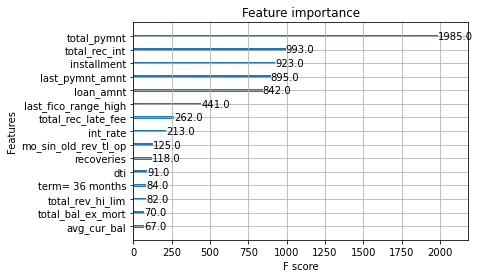

In [255]:
plt.figure(figsize=(40, 12))
xgb.plot_importance(model_xgb, max_num_features=15)

In [180]:
model_xgb_classifier = xgb.XGBClassifier(max_depth=5, random_state=1)

In [182]:
model_xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [256]:
df_result.loc[len(df_result)] = evaluation_result(model_xgb_classifier, "XGBClassifier", "train_set", X_train, y_train)
df_result.loc[len(df_result)] = evaluation_result(model_xgb_classifier, "XGBClassifier", "val_set", X_val, y_val)
df_result.loc[len(df_result)] = evaluation_result(model_xgb_classifier, "XGBClassifier", "test_set", X_test, y_test)

In [257]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416
3,decision_tree,train_set,0.995856,0.998790,0.989193
4,decision_tree,val_set,0.994489,0.996807,0.985657
5,decision_tree,test_set,0.994344,0.997313,0.985283
6,random_forest,train_set,0.987930,0.998704,0.968025
7,random_forest,val_set,0.986168,0.998189,0.963431
8,random_forest,test_set,0.985984,0.998171,0.962925
9,xgb_model,train_set,0.999163,0.999970,0.997829


### Gradient Boosting Classifier from sklearn

In [174]:
from sklearn.ensemble import GradientBoostingClassifier

In [187]:
model_gradient_boosting = GradientBoostingClassifier(n_estimators=150, 
                                                     min_samples_leaf=3,
                                                     random_state=1,
                                                     max_depth=5)

In [188]:
# Model runs very slowly
model_gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, min_samples_leaf=3, n_estimators=150,
                           random_state=1)

In [258]:
df_result.loc[len(df_result)] = evaluation_result(model_gradient_boosting, "GradientBoostingClassifier", "train_set", X_train, y_train)
df_result.loc[len(df_result)] = evaluation_result(model_gradient_boosting, "GradientBoostingClassifier", "val_set", X_val, y_val)
df_result.loc[len(df_result)] = evaluation_result(model_gradient_boosting, "GradientBoostingClassifier", "test_set", X_test, y_test)

In [259]:
df_result

,model,set,accuracy,auc_score,f1_score
0,Logistics,train_set,0.994863,0.999082,0.986573
1,Logistics,val_set,0.994732,0.998991,0.986265
2,Logistics,test_set,0.994789,0.999085,0.986416
3,decision_tree,train_set,0.995856,0.998790,0.989193
4,decision_tree,val_set,0.994489,0.996807,0.985657
5,decision_tree,test_set,0.994344,0.997313,0.985283
6,random_forest,train_set,0.987930,0.998704,0.968025
7,random_forest,val_set,0.986168,0.998189,0.963431
8,random_forest,test_set,0.985984,0.998171,0.962925
9,xgb_model,train_set,0.999163,0.999970,0.997829


In [261]:
df_result.sort_values(by="auc_score", ascending=False)

,model,set,accuracy,auc_score,f1_score
12,XGBClassifier,train_set,0.999244,0.999972,0.998040
9,xgb_model,train_set,0.999163,0.999970,0.997829
14,XGBClassifier,test_set,0.998743,0.999865,0.996748
11,xgb_model,test_set,0.998569,0.999852,0.996295
13,XGBClassifier,val_set,0.998677,0.999837,0.996575
15,GradientBoostingClassifier,train_set,0.997816,0.999825,0.994317
10,xgb_model,val_set,0.998541,0.999825,0.996222
17,GradientBoostingClassifier,test_set,0.997383,0.999733,0.993205
16,GradientBoostingClassifier,val_set,0.997412,0.999691,0.993282
2,Logistics,test_set,0.994789,0.999085,0.986416


In [262]:
df_result.sort_values(by="f1_score", ascending=False)

,model,set,accuracy,auc_score,f1_score
12,XGBClassifier,train_set,0.999244,0.999972,0.998040
9,xgb_model,train_set,0.999163,0.999970,0.997829
14,XGBClassifier,test_set,0.998743,0.999865,0.996748
13,XGBClassifier,val_set,0.998677,0.999837,0.996575
11,xgb_model,test_set,0.998569,0.999852,0.996295
10,xgb_model,val_set,0.998541,0.999825,0.996222
15,GradientBoostingClassifier,train_set,0.997816,0.999825,0.994317
16,GradientBoostingClassifier,val_set,0.997412,0.999691,0.993282
17,GradientBoostingClassifier,test_set,0.997383,0.999733,0.993205
3,decision_tree,train_set,0.995856,0.998790,0.989193


In [263]:
df_result.sort_values(by="accuracy", ascending=False)

,model,set,accuracy,auc_score,f1_score
12,XGBClassifier,train_set,0.999244,0.999972,0.998040
9,xgb_model,train_set,0.999163,0.999970,0.997829
14,XGBClassifier,test_set,0.998743,0.999865,0.996748
13,XGBClassifier,val_set,0.998677,0.999837,0.996575
11,xgb_model,test_set,0.998569,0.999852,0.996295
10,xgb_model,val_set,0.998541,0.999825,0.996222
15,GradientBoostingClassifier,train_set,0.997816,0.999825,0.994317
16,GradientBoostingClassifier,val_set,0.997412,0.999691,0.993282
17,GradientBoostingClassifier,test_set,0.997383,0.999733,0.993205
3,decision_tree,train_set,0.995856,0.998790,0.989193


In [269]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   model      18 non-null     object 
 1   set        18 non-null     object 
 2   accuracy   18 non-null     float64
 3   auc_score  18 non-null     float64
 4   f1_score   18 non-null     float64
dtypes: float64(3), object(2)
memory usage: 864.0+ bytes


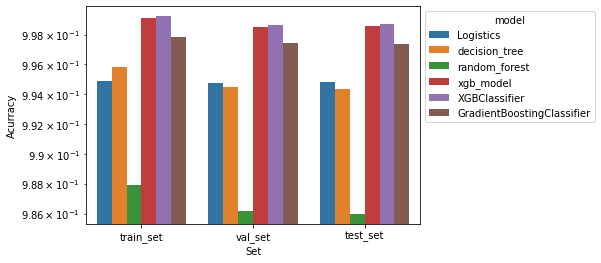

In [281]:
ax = sns.barplot(data=df_result, hue="model", y = "accuracy", x ="set")
ax.set_yscale("log")
_ = ax.set(xlabel="Set", ylabel="Acurracy")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

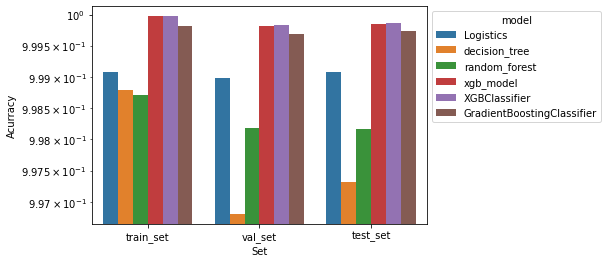

In [282]:
ax = sns.barplot(data=df_result, hue="model", y = "auc_score", x ="set")
ax.set_yscale("log")
_ = ax.set(xlabel="Set", ylabel="Acurracy")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

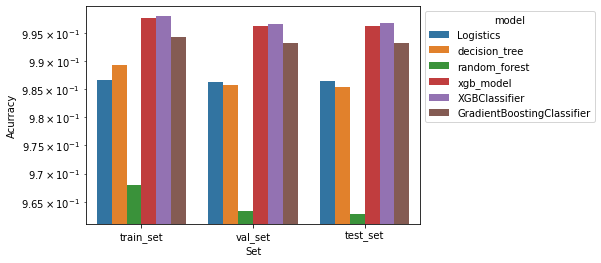

In [283]:
ax = sns.barplot(data=df_result, hue="model", y = "f1_score", x ="set")
ax.set_yscale("log")
_ = ax.set(xlabel="Set", ylabel="Acurracy")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

NameError: name 'df_test' is not defined